<a href="https://colab.research.google.com/github/imdeepmind/CrowdCounter/blob/master/Crowd_Counter_(Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Getting the dataset into proper place
!mkdir data
!cp '/content/drive/My Drive/datasets/dataset.zip' ./
!unzip -qq dataset.zip -d ./data/
!rm dataset.zip

In [ ]:
# Script to generate the processed.csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

labels = pd.read_csv('data/labels.csv')

preprocessed_labels = []
preprocessed_images = []

images = os.listdir("/content/data/frames/frames")

for (id, count) in labels.values:
  preprocessed_labels.append(count)
  preprocessed_images.append(images[id-1])

df = pd.DataFrame(columns=['image', 'count'])
df['image'] = preprocessed_images
df['count'] = preprocessed_labels

df.head()

df.to_csv('./data/processed.csv', index=False)

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Reading data
data = pd.read_csv("./data/processed.csv")

data.head()

,image,count
0,seq_001106.jpg,35
1,seq_001433.jpg,41
2,seq_000460.jpg,41
3,seq_000295.jpg,44
4,seq_001890.jpg,41


In [4]:
train, test = train_test_split(data, test_size=0.1, random_state=1969)

train.head()

,image,count
261,seq_000691.jpg,18
962,seq_000568.jpg,31
592,seq_000271.jpg,25
884,seq_001953.jpg,25
84,seq_000805.jpg,31


In [5]:
train_generator = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, rescale=1/255.)
test_generator = ImageDataGenerator(rescale=1/255.)

In [14]:
train_data = train_generator.flow_from_dataframe(train, 
                                                 directory='./data/frames/frames/', 
                                                 x_col='image', 
                                                 y_col='count', 
                                                 target_size=(640, 480),
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 batch_size=16,
                                                 shuffle=True)

test_data = test_generator.flow_from_dataframe(test, 
                                                 directory='./data/frames/frames/', 
                                                 x_col='image', 
                                                 y_col='count', 
                                                 target_size=(640, 480),
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 batch_size=16,
                                                 shuffle=True)


Found 1800 validated image filenames.
Found 200 validated image filenames.


In [8]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'Same', activation ='relu', input_shape = (640,480,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'Same', activation ='relu', input_shape = (640,480,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 512, kernel_size = 3, padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(4096, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4096, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4096, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1))

In [9]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 640, 480, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 320, 240, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 320, 240, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 320, 240, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 160, 120, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 160, 120, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 160, 120, 128)    

In [11]:
earlyStopper = EarlyStopping(patience=3, restore_best_weights=True)

In [15]:
history = model.fit(train_data, 
          steps_per_epoch=1800//16,
          validation_data=test_data,
          validation_steps=200//16,
          epochs=100,
          callbacks=[earlyStopper])

Epoch 1/100
112/112 [==============================] - 148s 1s/step - loss: 331.7489 - mae: 11.5127 - val_loss: 45.2337 - val_mae: 5.2510
Epoch 2/100
112/112 [==============================] - 147s 1s/step - loss: 57.4492 - mae: 6.0602 - val_loss: 57.9395 - val_mae: 5.8227
Epoch 3/100
112/112 [==============================] - 147s 1s/step - loss: 58.2834 - mae: 6.0879 - val_loss: 49.0920 - val_mae: 5.2823
Epoch 4/100
112/112 [==============================] - 148s 1s/step - loss: 59.2295 - mae: 6.1416 - val_loss: 44.3514 - val_mae: 5.1505
Epoch 5/100
112/112 [==============================] - 148s 1s/step - loss: 56.5742 - mae: 5.9967 - val_loss: 45.0424 - val_mae: 5.3709
Epoch 6/100
112/112 [==============================] - 148s 1s/step - loss: 59.1596 - mae: 6.1155 - val_loss: 53.9850 - val_mae: 5.5571
Epoch 7/100
112/112 [==============================] - 149s 1s/step - loss: 57.7431 - mae: 6.0662 - val_loss: 46.6654 - val_mae: 5.4743


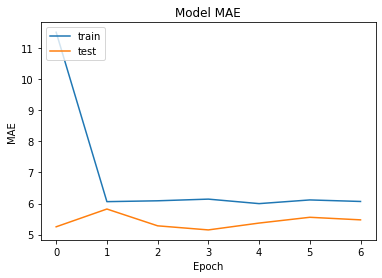

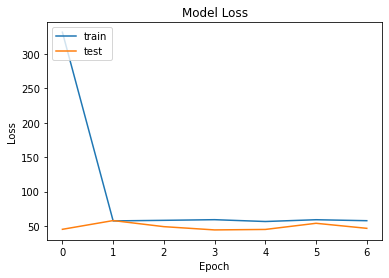

In [16]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model.save("best.h5")